In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
'''Trains a simple convnet on the MNIST dataset.

Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np

Using TensorFlow backend.


In [44]:
batch_size = 128
num_classes = 10
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 7s 119us/step - loss: 0.2632 - acc: 0.9206 - val_loss: 0.0572 - val_acc: 0.9808
Test loss: 0.05723402953627519
Test accuracy: 0.9808


array([[2.55904268e-07, 1.39071110e-08, 6.85280611e-06, 3.12924954e-06,
        1.06494564e-08, 4.46219817e-09, 3.27008554e-09, 9.99987245e-01,
        4.73717634e-08, 2.50406583e-06],
       [3.20763729e-06, 2.49420300e-05, 9.99965549e-01, 4.06200525e-06,
        2.91464763e-09, 3.35106165e-09, 1.43034219e-06, 3.49216434e-09,
        8.12050985e-07, 6.17292883e-11],
       [5.40509473e-06, 9.99128282e-01, 2.28736302e-04, 4.59426656e-06,
        1.07721025e-04, 3.36976836e-06, 1.36639908e-04, 3.34077515e-04,
        3.71899878e-05, 1.40207922e-05],
       [9.99922633e-01, 2.51893624e-07, 2.12697705e-05, 8.25799930e-07,
        3.33046586e-08, 5.25347286e-06, 4.45402002e-05, 2.59837475e-06,
        9.42924032e-07, 1.64843470e-06],
       [2.08605184e-06, 3.03851812e-06, 2.29683337e-06, 5.74533203e-07,
        9.98565853e-01, 6.74309604e-07, 1.59546089e-05, 5.38241329e-06,
        6.03199624e-06, 1.39810436e-03]], dtype=float32)

In [45]:
np.argmax(model.predict(x_test[:5]), -1)

array([7, 2, 1, 0, 4])

In [47]:
import tempfile, sys, os, pickle
sys.path.insert(0, os.path.abspath('..'))

from lpdn import convert_to_lpdn
lp_model = convert_to_lpdn(Model(inputs=model.inputs, outputs=model.layers[-2].output))
model.save_weights('tmp.h5')
lp_model.load_weights('tmp.h5')
lp_model.summary()

Tensor("input_2:0", shape=(?, 28, 28, 1, 2), dtype=float32)
Tensor("input_2:0", shape=(?, 28, 28, 1, 2), dtype=float32)
Tensor("conv2d_3_1/stack:0", shape=(?, 26, 26, 32, 2), dtype=float32)
Tensor("conv2d_3_1/stack:0", shape=(?, 26, 26, 32, 2), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1, 2)      0         
_________________________________________________________________
conv2d_3 (LPConv2D)          (None, 26, 26, 32, 2)     320       
_________________________________________________________________
conv2d_4 (LPConv2D)          (None, 24, 24, 64, 2)     18496     
_________________________________________________________________
max_pooling2d_2 (LPMaxPoolin (None, 12, 12, 64, 2)     0         
_________________________________________________________________
flatten_2 (LPFlatten)        (None, 9216, 2)           0         
______________

In [53]:
x_dist = np.stack([x_test, 0.5*np.ones_like(x_test)], -1)
print(x_dist.shape)
y_dist = lp_model.predict(x_dist)
print (y_dist.shape)

(10000, 28, 28, 1, 2)
(10000, 10, 2)


[7 2 1 0 4]


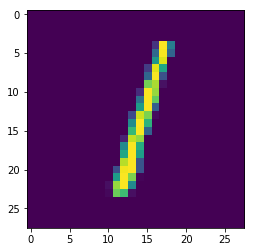

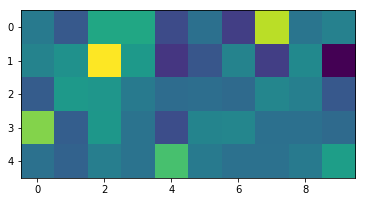

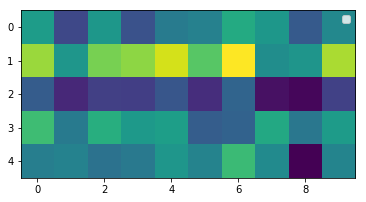

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.mlab as mlab
plt.imshow(x_dist[2, :, :, 0, 0])
plt.figure()
plt.imshow(y_dist[0:5, :, 0])
plt.figure()
plt.imshow(y_dist[0:5, :, 1])
plt.legend()
print (np.argmax(y_dist[0:5, :, 0], 1))